## Proceso de Carga de Datos, Transformación y Almacenamiento

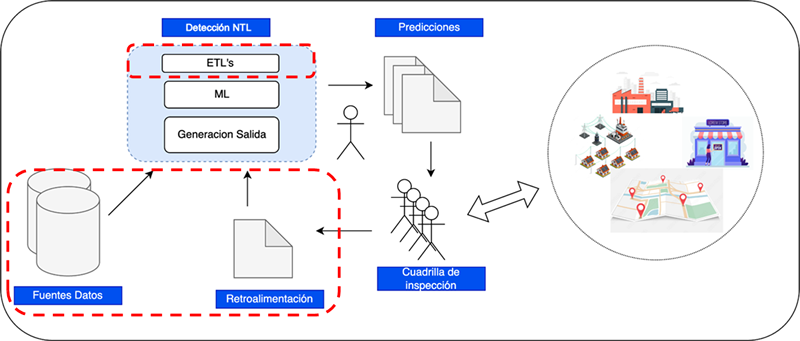

En esta primera etapa se debe cargar los nuevos datos de consumo e inspecciones en las bases de datos del módulo de predicción. Para ello, seguir estos pasos:
1. **Cargar datos de consumo mensual**: Cargar los archivos Excel (.xlsx) o Csv (.csv) en la carpeta *"data/consumo"*, con el formato de exportación normal. Una vez procesados estos se moverán a la carpeta *"data/procesados"*.
2. **Cargar datos de inspecciones**: Cargar archivos Excel (.xlsx) o Csv (.csv) en la carpeta *"data/inspecciones"*. El formato esperado para estos archivos viene dado por el reporte de índice de riesgo obtenido en una ejecución anterior del módulo de predicción. Una vez procesados estos archivos se moverán a la carpeta *"data/procesados"*.
3. **Ejecutar celdas ETL**: Las celdas de abajo permiten obtener las series de consumo etiquetadas junto con variables categóricas y derivadas, tanto para el set de entrenamiento como para los consumos del mes actual. Luego de ejecutarlas, se podrá llevar a cabo el entrenamiento del modelo de predicción, y con ello obtener las predicciones para guiar las inspecciones en campo, desde la notebook *train_predicciones.ipynb*.

In [1]:
######## CONFIGURACIONES PRELIMINARES Y CARGA DE LIBRERÍAS DEL MÓDULO ##########
## {Formato viejo de archivo de multas: **Recordar que la estructura de estos archivos debe contener una columna *"Código novedad"*, sin valor para las inspecciones sin multa y con algún valor para aquellas inspecciones con multa**.}
import os
import pandas as pd
import warnings
import io
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
module_path = os.path.abspath(os.path.join('../../'))
import sys
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocessing import etl

#### CARGA DE ARCHIVOS DE CONSUMO
Se utilizan los archivos que están dentro de la carpeta "data/consumo", los cuales deben tener formato excel (.xlsx) o csv (.csv), y serán movidos a la carpeta "data/procesados"

In [2]:
%%time
df_historico, df_instalacion_cuenta = etl.concatenar_nuevos_datos_consumo()

---Importación de datos nuevos de consumos---
Tamaño original df datos histórico: (22864856, 17)
Tamaño datos agregados: (0, 0)
Tamaño final df datos histórico: (18904050, 17)
Cantidad total de Cuentas: 1412352
Cantidad total de Instalaciones: 696867
---Finalizado: Importación de datos nuevos de consumos---
CPU times: total: 2min 18s
Wall time: 1min 21s


#### CARGA DE ARCHIVOS DE INSPECCIONES
Se buscan archivos existentes en "data/inspecciones" en formato Excel (.xlsx). En este caso, los archivos que se esperan tienen como fuente el Reporte de Instalaciones con alto índice de riesgo, el mismo que se emite al final del módulo de predicción (Fase de Retroalimentación).
Luego de agregarse a la base de datos del módulo de predicciones, los archivos recolectados serán movidos a la carpeta "data/procesados". El formato esperado para estos archivos es similar al reporte de índice de riesgo obtenido en ejecuciones anteriores del módulo, y es el siguiente (los nombres deben coincidir de forma exacta):

 1. *Fecha*: Contiene la fecha de realización de la inspección al cliente. Su formato esperado es: **dd/mm/aaaa** (También debe coincidir de forma exacta el formato en todas las filas).
   
 2. *Instalacion*: Contiene el número de instalación asociado a la inspección, que luego se vinculará con el número de cuenta mediante el listado maestro de consumos.
    
 3. *Inspecciones realizadas*: Columna que indica, para cada caso, si la inspección se realizó para esa instalación. Su formato es: *1* si se realizó inspección, y *0* si no se realizó inspección. Sirve para permitir el uso de un reporte de índice de riesgo sin necesidad de remover la lista completa de instalaciones, aún cuando no se efectuó la totalidad de inspecciones.
    
 4. *Notificaciones*: Esta columna permite distinguir los casos de infracción y los casos en los que no se detectó infracción al realizar la inspección. Su formato también es *1* para infracción y *0* para no infracción. Permite identificar los casos positivos y negativos para la clase *fraude* en el dataset de entrenamiento.

In [3]:
%%time
df_historico_inspecciones = etl.concatenar_nuevos_datos_inspecciones()

---Importación de datos nuevos de inspecciones---
Tamaño original df datos histórico inspecciones: (55516, 9)
Tamaño datos nuevos datos de inspecciones: (0, 0)
Tamaño final df datos histórico inspecciones: (55516, 9)
---Finalizado: Importación de datos nuevos de inspecciones---
CPU times: total: 219 ms
Wall time: 162 ms


#### ETIQUETADO DE VALORES DE CONSUMO PARA LAS INSTALACIONES INSPECCIONADAS
En esta sección se elabora una base de datos que contendrá los consumos etiquetados como fraude o no fraude, solamente para las instalaciones que figuran en las inspecciones registradas. Para el caso de las situaciones de fraude, se tomarán el o los períodos en que se registró fraude como consumo/s fraudulentos, y el resto como no fraudulentos. Se incluyen aquí todos los consumos del período correspondiente para todas las instalaciones que figuran inspeccionadas.

In [4]:
%%time
df_fraudes_completo_etiquetado = etl.etiquetar_consumos_inspecciones_train()

---Generación de datos de consumo etiquetados---
Tamaño original df datos histórico: (18904050, 17)
Tamaño original df datos histórico fraudes: (55516, 9)
Tamaño final df datos histórico completos etiquetados: (1126711, 20)
---Finalizado: Generación de datos de consumo etiquetados---
CPU times: total: 14.5 s
Wall time: 14.5 s


#### GENERACIÓN Y ETIQUETADO DE SERIES DE CONSUMO PARA ENTRENAMIENTO
En esta fase se lleva a cabo la elaboración de las series de consumo para el set de entrenamiento. Se procesan todos los datos de inspecciones agregados en el paso anterior, vinculándolos con los datos de consumo, para armar las series con la etiqueta correspondiente, de acuerdo al hallazgo de situación de fraude o no en el consumo final de la serie. Cada serie incluye doce meses anteriores de consumo.

In [8]:
%%time
df_wide_normal_and_fraud = etl.series_de_consumo_etiquetadas()

---Generación de series de consumo etiquetadas---


100%|██████████| 13/13 [01:04<00:00,  4.97s/it]


Tamaño final series etiquetadas: (27483, 32)
---Finalizado: Generación de series de consumo etiquetadas---
CPU times: total: 1min 18s
Wall time: 1min 17s


#### GENERACIÓN DE FEATURES ESTADÍSTICAS Y TEMPORALES SOBRE LAS SERIES ETIQUETADAS
Aquí se computan las distintas features sintéticas que también formarán parte del dataset en las fases posteriores. En este caso se computan las features correspondientes al set de datos de entrenamiento, es decir, aquellos registros de inspecciones para casos de multa y casos sin multa, vinculando los datos de las series de consumo elaboradas en el paso anterior.

In [9]:
df_series_features = etl.cleaning_feature_engineering()

---Generación de features de series de consumo etiquetadas---
-- Usando datos históricos de feature eng: (70344, 115) ../../data/historico/df_series_features_train.parquet
Tamaño datos wide a agregar (nuevos datos no catalogados antes): (62, 32)
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Tamaño final series con features: (70406, 115)
---Finalizado: Generación de features de series de consumo etiquetadas---


#### PROCESAMIENTO DE DATASET FINAL PARA ENTRENAMIENTO
Seguidamente, en esta fase se generan los datos necesarios para poder efectuar el entrenamiento del modelo de predicción. Se generan y guardan *X*, *y* y *df_features_selected*, que contendrán las series de consumo acompañadas de variables sintéticas y categóricas (X), la indicación de clase *Fraude* o *No Fraude* (y), y las variables seleccionadas por el método Boruta (df_features_selected) respectivamente.

In [ ]:
%%time
X, y, df_features_selected = etl.feature_selection_dataset_entrenamiento()

---Selección de Features y Armado de Dataset de Entrenamiento---
Tamaño original X: (70406, 114), Tamaño original y: (70406,)


 40%|████      | 2/5 [07:33<11:25, 228.40s/it]

#### ARMADO DE LAS SERIES DE CONSUMO PARA EL MES ACTUAL
En esta fase se arman las series temporales que ingresarán posteriormente a la fase de generación de features sintéticas del módulo. Sobre estas series se deben computar luego las variables sintéticas con la librería *TSFEL*.

In [3]:
%%time
series_mes = etl.series_de_consumo_mes_especifico()#,mes='2022/12'

---Generación de series de consumo para predicción de mes específico: 2023/10---
Filtrado de datos del período
Consumos reales/estimados: Contabilizando cantidad de estimaciones
Estados: Contabilizando por tipo
Categorías: Contabilizando categorías del período y última categoría por instalación
Categorías: Identificando categorias mas frecuentes del período por instalación
Categorías: Contabilizando cambios
Iniciando armado de series
Iniciando unión de series y características
----Finalizado armado de series del mes----
CPU times: total: 16min 29s
Wall time: 15min 50s


#### CÓMPUTO DE FEATURES TSFEL PARA LAS SERIES DE CONSUMO DEL MES ACTUAL
En esta fase se computan las features sintéticas *TSFEL* para las series de consumo generadas en el paso anterior. Las series temporales etiquetadas y con sus features generadas ingresarán posteriormente a la fase de *Inferencia* del módulo. En dicha fase, luego de haber efectuado el re-entrenamiento del modelo de predicción LGBM con los últimos datos de inspecciones registrados, se emitirá el *Reporte de Índice de Riesgo* para las instalaciones registradas, que permitirá la posterior planificación de inspecciones para el nuevo período. **Este cómputo se lleva a cabo de manera incremental, por lo que es posible, en caso de que no se haya finalizado el proceso correctamente, reanudarlo más tarde**.

Con este paso se concluye la etapa de ETL, al disponer de todos los datos necesarios para efectuar entrenamiento e inferencia (predicción de valores nuevos de índice de riesgo o probabilidad de fraude). Las tareas siguientes se ejecutan en la notebook **train_predicciones.ipynb**.

In [4]:
# SERIES A ESPERAR QUE SEAN GENERADAS:
## DEBERÍAN GENERARSE MÁS DATOS DE INSTALACIONES, POR LAS AGREGADAS EN CADA MES
import pandas as pd
df_historico = pd.read_parquet('../../data/historico/df_raw_completo.parquet')
ant = df_historico.query('mesfac == "2023/09"').instalacion.nunique()
act = df_historico.query('mesfac == "2023/10"').instalacion.nunique()
print(f'instalaciones mes anterior: {ant}')
print(f'instalaciones mes actual: {act}')

instalaciones mes anterior: 691968
instalaciones mes actual: 695131


In [ ]:
%%time
num_bloques = 30
series_features = etl.cleaning_feature_engineering_mes_especifico(num_bloques=num_bloques)

---Generación de features de series de consumo de mes específico---
Continuamos desde batch 11...
*** Feature extraction started ***


In [3]:
### OPCIONAL: CHEQUEAR PROGRESO
import pandas as pd
df_parcial = pd.read_parquet('../../data/historico/df_series_features_mes_parcial.parquet')
print(f'df_parcial: {df_parcial.shape}')
#df_parcial.tail()

df_parcial: (695131, 115)


In [5]:
# REPORTE DE REGISTROS DE CONSUMO POR MES
df_historico.groupby('date').size()

date
2021-07-01    666178
2021-08-01    666749
2021-09-01    609019
2021-10-01    669822
2021-11-01    670203
2021-12-01    670790
2022-01-01    639999
2022-02-01    672971
2022-03-01    673833
2022-04-01    674394
2022-05-01    674872
2022-06-01    676186
2022-07-01    677301
2022-08-01    678540
2022-09-01    680011
2022-10-01    680776
2022-11-01    681040
2022-12-01    680995
2023-01-01    681322
2023-02-01    681895
2023-03-01    682271
2023-04-01    682917
2023-05-01    683488
2023-06-01    683931
2023-07-01    687150
2023-08-01    690179
2023-09-01    692025
2023-10-01    695193
dtype: int64